In [15]:
## simulate kmer data with hierarchical rules
import itertools
import numpy as np
import pandas as pd

# Use nucleotides with U instead of T since the patterns use U.
nucleotides = ['A', 'C', 'G', 'U']

# Generate all possible 5-mers in sorted order (1024 possibilities)
kmers = sorted(''.join(p) for p in itertools.product(nucleotides, repeat=5))
num_kmers = len(kmers)  # Should be 1024

# Simulation parameters
num_samples = 2500       # number of samples (rows)
total_count = 76        # each sample's 4-mer counts sum to 77 (80 nt -> 77 overlapping 4-mers)
delta_high = 0.003      # bias strength for high-importance motifs
delta_low = 0.001       # bias strength for low-importance motifs
noise_std = 0.05        # standard deviation of noise added to the expression value

# Define pattern matching functions that apply hierarchical rules:
def positive_bias(kmer, s):
    # High importance: matches "CAU*" (starts with "CAU") or "*CAU" (ends with "CAU")
    if kmer.startswith("CAU") or kmer.endswith("CAU"):
        return delta_high * s
    # Low importance: matches "A**U" (starts with A and ends with U)
    elif kmer[0] == 'A' and kmer[-1] == 'U':
        return delta_low * s
    else:
        return 0.0

def negative_bias(kmer, s):
    # High importance: matches "UAC*" (starts with "UAC") or "*UAU" (ends with "UAU")
    if kmer.startswith("UAC") or kmer.endswith("UAC"):
        return -(delta_high + 0.001) * s # slightly stronger negative bias
    # Low importance: matches "C**G" (starts with C and ends with G)
    elif kmer[0] == 'C' and kmer[-1] == 'G':
        return -(delta_low - 0.0005) * s
    else:
        return 0.0

# Prepare a list to hold simulated data rows.
data_rows = []

# Set a random seed for reproducibility.
np.random.seed(42)

for _ in range(num_samples):
    # Sample a latent signal s that will drive both the feature probabilities and expression.
    s = np.random.uniform(0, 1)
    
    # Initialize probability vector for each 4-mer with a uniform baseline.
    baseline = 1.0 / num_kmers
    probs = []
    
    for kmer in kmers:
        p = baseline
        # Apply positive bias if the kmer qualifies.
        p += positive_bias(kmer, s)
        # Apply negative bias if the kmer qualifies.
        p += negative_bias(kmer, s)
        # Ensure probability is non-negative (set a small floor)
        if p < 0:
            p = 1e-6
        probs.append(p)
    
    # Renormalize probabilities to sum to 1.
    probs = np.array(probs)
    probs /= probs.sum()
    
    # Draw counts for each 4-mer from a multinomial with total_count trials.
    counts = np.random.multinomial(total_count, probs)
    
    # Generate the expression value as latent s plus Gaussian noise, then clip to [0,1].
    expr = s + np.random.normal(0, noise_std)
    expr = np.clip(expr, 0, 1)
    
    # Create a dictionary for this sample: keys are kmer strings and one "expression" column.
    sample_dict = {kmer: count for kmer, count in zip(kmers, counts)}
    sample_dict["expression"] = expr
    data_rows.append(sample_dict)

# Create a DataFrame from the simulated data.
df = pd.DataFrame(data_rows)

# Verify that each row's k-mer counts sum to total_count (77)
row_sums = df[kmers].sum(axis=1)
assert np.all(row_sums == total_count), "Not all rows sum to 77!"

# Save the DataFrame to CSV.
output_csv = "simulated_5mer_data.csv"
df.to_csv(output_csv, index=False)
print(f"Simulated data saved to '{output_csv}'")
print("Data generation complete.")

Simulated data saved to 'simulated_5mer_data.csv'
Data generation complete.


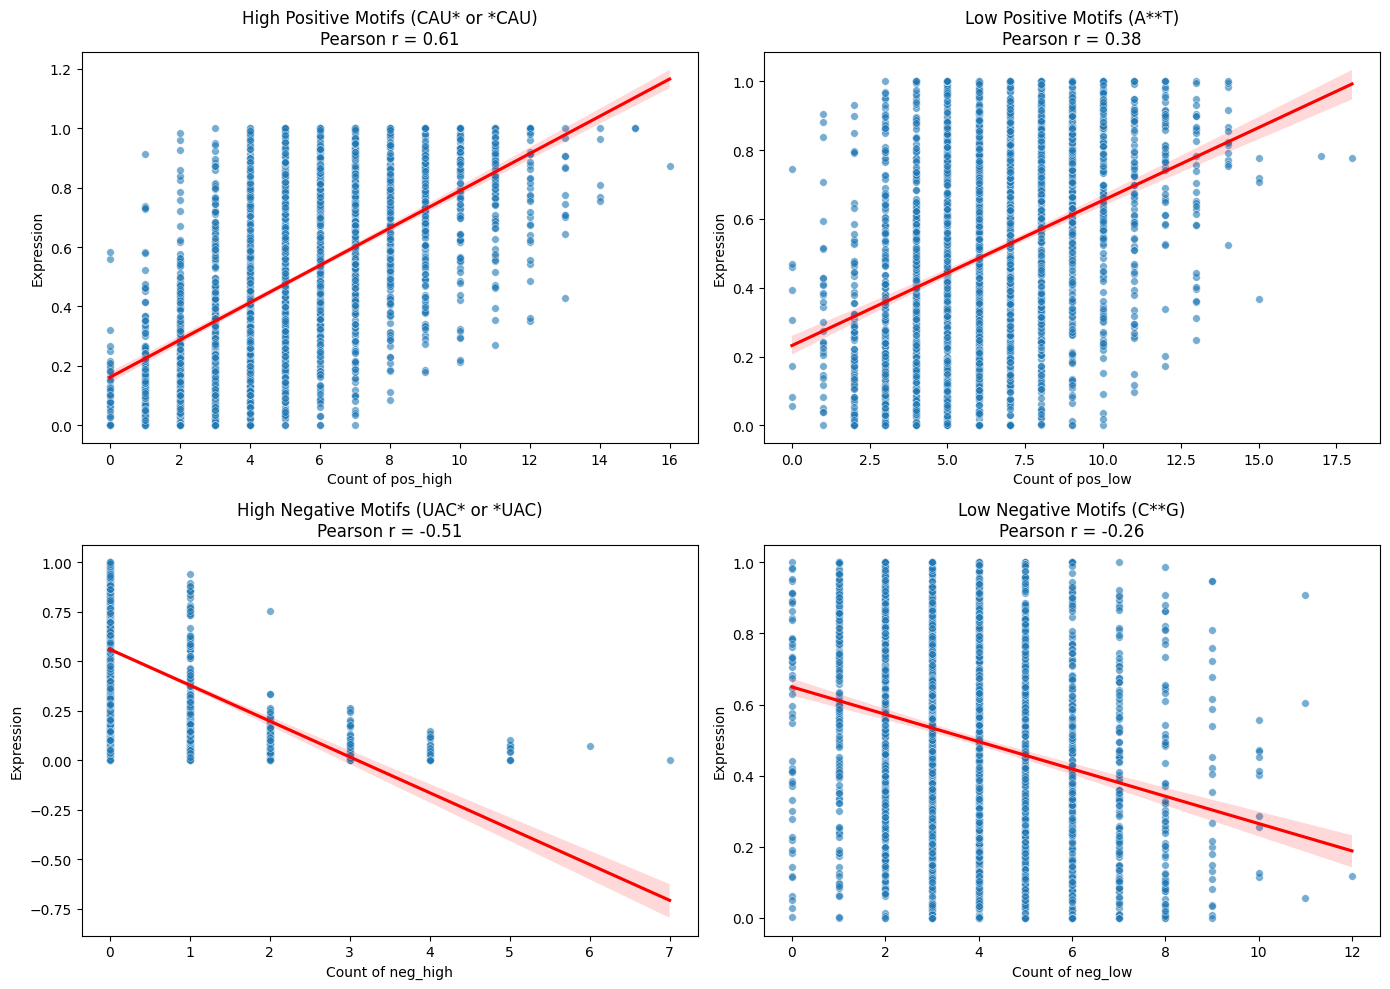

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load simulated data from CSV
df = pd.read_csv("simulated_5mer_data.csv")

# Identify the k-mer columns (all columns except 'expression')
kmer_cols = [col for col in df.columns if col != 'expression']

# Define helper functions to assign a 4-mer to a category.
def is_pos_high(kmer):
    # High positive: starts or ends with "CAU"
    return kmer.startswith("CAU") or kmer.endswith("CAU")

def is_pos_low(kmer):
    # Low positive: starts with A and ends with U, and not already high positive.
    return (kmer[0] == 'A' and kmer[-1] == 'U') and not is_pos_high(kmer)

def is_neg_high(kmer):
    # High negative: starts with "UAC" or ends with "UAU"
    return kmer.startswith("UAC") or kmer.endswith("UAC")

def is_neg_low(kmer):
    # Low negative: starts with C and ends with G, and not already high negative.
    return (kmer[0] == 'C' and kmer[-1] == 'G') and not is_neg_high(kmer)

# Group the k-mers based on the defined patterns.
pos_high_cols = [col for col in kmer_cols if is_pos_high(col)]
pos_low_cols  = [col for col in kmer_cols if is_pos_low(col)]
neg_high_cols = [col for col in kmer_cols if is_neg_high(col)]
neg_low_cols  = [col for col in kmer_cols if is_neg_low(col)]

# Sum counts for each group.
df['pos_high'] = df[pos_high_cols].sum(axis=1)
df['pos_low']  = df[pos_low_cols].sum(axis=1)
df['neg_high'] = df[neg_high_cols].sum(axis=1)
df['neg_low']  = df[neg_low_cols].sum(axis=1)

# Set up plot labels for clarity.
categories = ['pos_high', 'pos_low', 'neg_high', 'neg_low']
titles = {
    'pos_high': 'High Positive Motifs (CAU* or *CAU)',
    'pos_low':  'Low Positive Motifs (A**T)',
    'neg_high': 'High Negative Motifs (UAC* or *UAC)',
    'neg_low':  'Low Negative Motifs (C**G)'
}

# Create scatter plots for each motif group versus expression.
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, cat in enumerate(categories):
    ax = axes[i]
    sns.scatterplot(x=df[cat], y=df['expression'], ax=ax, s=30, alpha=0.6)
    
    # Fit a linear regression line for visualization.
    sns.regplot(x=df[cat], y=df['expression'], scatter=False, ax=ax, color='red')
    
    # Calculate Pearson correlation coefficient.
    r, p_val = pearsonr(df[cat], df['expression'])
    ax.set_title(f"{titles[cat]}\nPearson r = {r:.2f}")
    ax.set_xlabel(f"Count of {cat}")
    ax.set_ylabel("Expression")

plt.tight_layout()
plt.show()
